# Data Analysis and Plotting
Questions/Insights:
- Experience on the team vs position on table, look at average team contract length vs position on table
- Value/wage vs ranking (plot ranking on x, average wage of that ranking on y)
- Which country has the most valuable players?
### TO DO:
- Create summary files
- Export everything onto colab



In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import requests
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from plotly.subplots import make_subplots


Read in raw data. Final DataFrames are:
- player_data
- league_data
- collegiate_data

In [39]:
player_data = pd.read_csv("data/player_data.csv", index_col=0).reset_index().drop("index", axis = 1)
collegiate_data = pd.read_csv("data/collegiate_soccer_data.csv", index_col=0).reset_index().drop("index", axis = 1)
bl1_data = pd.read_csv("data/api-data/BL1_2022.csv", index_col=0)
bl1_data["league"] = "BL1"
fl1_data = pd.read_csv("data/api-data/FL1_2022.csv", index_col=0)
fl1_data["league"] = "FL1"
pd_data = pd.read_csv("data/api-data/PD_2022.csv", index_col=0)
pd_data["league"] = "PD"
pl_data = pd.read_csv("data/api-data/PL_2022.csv", index_col=0)
pl_data["league"] = "PL"
sa_data = pd.read_csv("data/api-data/SA_2022.csv", index_col=0)
sa_data["league"] = "SA"
league_data = pd.concat([bl1_data, fl1_data, pd_data, pl_data, sa_data]).reset_index().drop("index", axis = 1)


### Extra source for continents data:
https://statisticstimes.com/geography/countries-by-continents.php <br>
Webscraped here:

In [40]:
url = "https://statisticstimes.com/geography/countries-by-continents.php"
html = requests.get(url).text
soup = BeautifulSoup(html, "html.parser")
table = soup.find("table", {"style":"width:945px;display:table;border:1px solid #0000FF;"})
header = [th.text for th in table.find_all("th")]
tbody = table.find("tbody")
content = [[td.text for td in tr.find_all("td")] for tr in tbody.find_all("tr")]
countries = pd.DataFrame(data = content, columns=header).drop("No", axis = 1)
countries["Region 2"] = countries["Region 2"].replace(r"", "None")
countries

,Country or Area,ISO-alpha3 Code,M49 Code,Region 1,Region 2,Continent
0,Afghanistan,AFG,004,Southern Asia,None,Asia
1,Åland Islands,ALA,248,Northern Europe,None,Europe
2,Albania,ALB,008,Southern Europe,None,Europe
3,Algeria,DZA,012,Northern Africa,None,Africa
4,American Samoa,ASM,016,Polynesia,None,Oceania
...,...,...,...,...,...,...
244,Wallis and Futuna Islands,WLF,876,Polynesia,None,Oceania
245,Western Sahara,ESH,732,Northern Africa,None,Africa
246,Yemen,YEM,887,Western Asia,None,Asia
247,Zambia,ZMB,894,Eastern Africa,Sub-Saharan Africa,Africa


Rename United States of America to United States, Russian Federation to Russia, and others (checked manually)


In [41]:
countries["Country or Area"] = countries["Country or Area"].replace("United States of America", "United States")
countries["Country or Area"] = countries["Country or Area"].replace("Russian Federation", "Russia")
countries["Country or Area"] = countries["Country or Area"].replace("Venezuela (Bolivarian Republic of)", "Venezuela")
countries["Country or Area"] = countries["Country or Area"].replace("Bolivia (Plurinational State of)", "Bolivia")
countries["Country or Area"] = countries["Country or Area"].replace("Côte d’Ivoire", "Côte d'Ivoire")
countries["Country or Area"] = countries["Country or Area"].replace("Democratic Republic of the Congo", "Congo DR")
countries["Country or Area"] = countries["Country or Area"].replace("United Republic of Tanzania", "Tanzania")
countries["Country or Area"] = countries["Country or Area"].replace("China", "China PR")
countries["Country or Area"] = countries["Country or Area"].replace("Iran (Islamic Republic of)", "Iran")
countries["Country or Area"] = countries["Country or Area"].replace("Republic of Korea", "Korea Republic")
countries["Country or Area"] = countries["Country or Area"].replace("Guinea-Bissau", "Guinea Bissau")
countries["Country or Area"] = countries["Country or Area"].replace("Ireland", "Republic of Ireland")
countries["Country or Area"] = countries["Country or Area"].replace("Viet Nam", "Vietnam")
player_data["nationality"] = player_data["nationality"].replace("England", "United Kingdom of Great Britain and Northern Ireland")
player_data["nationality"] = player_data["nationality"].replace("Northern Ireland", "United Kingdom of Great Britain and Northern Ireland")

## 1. Club stats vs position on table, etc - anything involving joining API data and webscraped data
- Average contract length of each team vs position on table
- Average team wage vs position on table, compare all leagues and individual leagues
- Age vs overall stat number - age x axis, average stat y axis

### Correlation analysis
Pandas series to give average contract length group by team, per league. Compare correlations across the big five leagues somehow 
<br>
Insight: Are teams with more "secure" players more successful? better team chemistry? What does this even tell me?
<br><br>
Heatmap for many different correlations??

slope = -2.3735920577239296
intercept = 303.88543401011253
R^2 = -0.9073611790041398


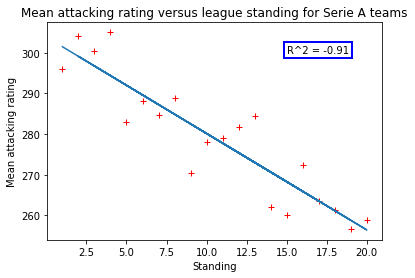

In [42]:
contract_len_avg = player_data.groupby("team").agg({"attacking":"mean"}).merge(league_data, on="team")[["team", "league", "position", "attacking"]]
league = contract_len_avg[contract_len_avg["league"] == "SA"]
plt.plot(league["position"], league["attacking"], "r+")
theta = np.polyfit(league["position"], league["attacking"], 1)
y_line = theta[1] + theta[0]*league["position"]
plt.plot(league["position"], y_line)
correlation = np.corrcoef(league["position"], league["attacking"])[0,1]
# y = mx + b, theta[0] = m, theta[1] = b
print(f"slope = {theta[0]}")
print(f"intercept = {theta[1]}") 
print(f"R^2 = {correlation}") 
plt.title("Mean attacking rating versus league standing for Serie A teams")
plt.xlabel("Standing")
plt.ylabel("Mean attacking rating")
plt.annotate(f"R^2 = {round(correlation, 2)}", (15, 300), bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="b", lw=2))
plt.show()

Function to return slope of best fit, intercept of best fit, and correlation, between x and y variables:

In [43]:
def linear_data(x, y):
    """Returns tuple of slope, intercept, pearson's correlation coefficient"""
    theta = np.polyfit(x, y, 1)
    correlation = np.corrcoef(x, y)[0,1]
    return theta[0], theta[1], correlation

Function to return correlation data per league (df). Returns slope, intercept, correlation between any two given variables per league. Variable names as strings, they are column headers from league_data and player_data, and aggregate function to apply to Y variable

In [44]:
def league_correlation_data(X, Y, X_agg, Y_agg):
    df = player_data.merge(league_data, on="team").groupby(["league", "team"]).aggregate(x_agg = (X, X_agg), y_agg = (Y, Y_agg))
    slope = df.groupby("league").apply(lambda d:linear_data(x = d["x_agg"], y = d["y_agg"])[0])
    intercept = df.groupby("league").apply(lambda d:linear_data(x = d["x_agg"], y = d["y_agg"])[1])
    correlation = df.groupby("league").apply(lambda d:linear_data(x = d["x_agg"], y = d["y_agg"])[2])
    linear_stats = pd.DataFrame({"slope":slope, "intercept":intercept, "correlation":correlation})
    linear_stats["x_name"], linear_stats["x_agg"], linear_stats["y_name"], linear_stats["y_agg"] = X, X_agg, Y, Y_agg
    linear_stats.reset_index(inplace = True)
    return linear_stats

Heat maps: 
- league on one axis, variable on the other
- variable vs variable, will create symmetric heat map
<br>
We are plotting correlations between each pair of variables here

We are only looking at mean as the aggregates to compare (for now). Create data for all possible combinations:

In [45]:
columns = ['overall', 'contract_length', 'height', 'weight', 'value', 'attacking', 'skill', 'mentality', 'defending', 'position', 'wage']
correlation_data = pd.DataFrame(columns=["league", "slope", "intercept", "correlation", "x_name", "x_agg", "y_name", "y_agg"])
for x in columns:
    for y in columns:
        correlation_data = pd.concat([correlation_data, league_correlation_data(X = x, Y = y, X_agg="mean", Y_agg="mean")], axis = 0)

Manually look at different leagues. Start with PL <br>
<br>
Seaborn help source for heatmaps: https://seaborn.pydata.org/generated/seaborn.heatmap.html

<AxesSubplot:title={'center':'Correlation between different average variables in league FL1'}, xlabel='mean variable', ylabel='mean variable'>

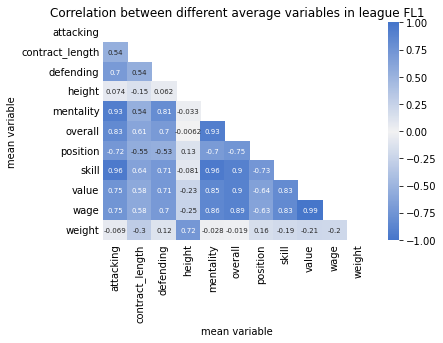

In [46]:
lg = "FL1" # change this variable for the league
p = correlation_data[correlation_data["league"] == lg].pivot(index = "x_name", columns = "y_name", values = "correlation")
mask = np.zeros_like(p)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(p, annot=True, mask = mask, center = 0, cmap = sns.diverging_palette(255,255, as_cmap=True), vmax=1, vmin=-1, annot_kws={"size": 7})
ax.tick_params(axis='both', which='both', length=0)
ax.set(title = f"Correlation between different average variables in league {lg}", xlabel="mean variable", ylabel="mean variable")
ax

Now plot league vs variables correlation with position heatmap:

<AxesSubplot:title={'center':'Correlation between position on table and other average \nvariables across the top five European leagues'}, xlabel='mean variable', ylabel='league'>

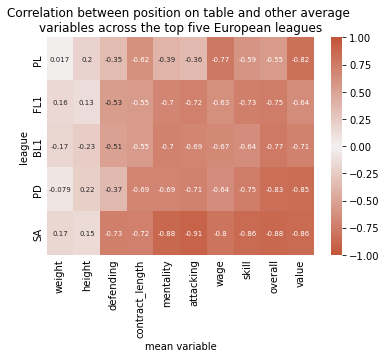

In [47]:
p = correlation_data[(correlation_data["x_name"] == "position") & (correlation_data["y_name"] != "position")].pivot(index = "league", columns = "y_name", values = "correlation")
p["abs_sum_1"] = p.abs().sum(axis=1) # create dummy column just for sorting
p.sort_values(by="abs_sum_1", ascending=True, inplace=True, axis=0) # values sorted on y-axis, so that cells with stronger correlations are at the bottom
p.loc["abs_sum_0",:] = p.abs().sum(axis=0) # create dummy column just for sorting
p.sort_values(by="abs_sum_0", ascending=True, inplace=True, axis=1) # values sorted on x-axis so that cells with stronger correlations are towards the right
p.drop("abs_sum_1", axis=1, inplace=True) # drop dummy columns
p.drop("abs_sum_0", axis=0, inplace=True)
ax = sns.heatmap(p, annot=True, center = 0, cmap = sns.diverging_palette(20,20, as_cmap=True), vmax=1, vmin=-1, annot_kws={"size": 7})
ax.tick_params(axis='both', which='both', length=0)
ax.set(title = "Correlation between position on table and other average \nvariables across the top five European leagues", xlabel="mean variable")
ax

The series following is the average correlations with position on table:

In [48]:
p.abs().mean(axis=0).sort_values(ascending=False)

y_name
value              0.778014
overall            0.757060
skill              0.713166
wage               0.702148
attacking          0.676871
mentality          0.672674
contract_length    0.626713
defending          0.497023
height             0.184613
weight             0.119941
dtype: float64

## 2. Nationality vs value/success, world vs value/success, etc. 
Also look at success? Which countries has the most successful players? <br><br>
https://plotly.com/python/choropleth-maps/ <br>
- Value: average value per country,most people with above a certain value? same for ranking 
<br>
DataFrame joining player_data and countries on country name:

In [49]:
df = player_data.merge(countries, left_on="nationality", right_on="Country or Area")[["nationality", "overall", "value", "wage", "ISO-alpha3 Code", "Continent"]].groupby(["Continent", "nationality", "ISO-alpha3 Code"]).describe().reset_index()
df = df[df["Continent"] == "Europe"]
df

Continent                                        nationality  \
                                                                   
72     Europe                                            Albania   
73     Europe                                            Austria   
74     Europe                                            Belarus   
75     Europe                                            Belgium   
76     Europe                             Bosnia and Herzegovina   
77     Europe                                           Bulgaria   
78     Europe                                            Croatia   
79     Europe                                            Denmark   
80     Europe                                            Estonia   
81     Europe                                      Faroe Islands   
82     Europe                                            Finland   
83     Europe                                             France   
84     Europe                                            Germany   
85     Europe                                             Greece   
86     Europe                                            Hungary   
87     Europe                                            Iceland   
88     Europe                                              Italy   
89     Europe                                             Latvia   
90     Europe                                          Lithuania   
91     Europe                                         Luxembourg   
92     Europe                                              Malta   
93     Europe                                         Montenegro   
94     Europe                                        Netherlands   
95     Europe                                    North Macedonia   
96     Europe                                             Norway   
97     Europe                                             Poland   
98     Europe                                           Portugal   
99     Europe                                Republic of Ireland   
100    Europe                                            Romania   
101    Europe                                             Russia   
102    Europe                                             Serbia   
103    Europe                                           Slovakia   
104    Europe                                           Slovenia   
105    Europe                                              Spain   
106    Europe                                             Sweden   
107    Europe                                        Switzerland   
108    Europe                                            Ukraine   
109    Europe  United Kingdom of Great Britain and Northern I...   

    ISO-alpha3 Code overall                                                 \
                      count       mean       std   min    25%   50%    75%   
72              ALB    47.0  67.510638  5.535939  57.0  63.50  67.0  71.00   
73              AUT   305.0  66.114754  5.608670  54.0  63.00  66.0  69.00   
74              BLR     4.0  61.500000  3.696846  58.0  58.75  61.0  63.75   
75              BEL   313.0  66.888179  6.931230  54.0  62.00  67.0  71.00   
76              BIH    63.0  69.396825  4.887574  58.0  66.00  69.0  72.00   
77              BGR    23.0  63.826087  3.663731  57.0  62.00  64.0  66.00   
78              HRV   154.0  69.240260  5.968386  51.0  65.00  69.0  73.00   
79              DNK   301.0  65.388704  6.749203  50.0  62.00  66.0  70.00   
80              EST     6.0  61.500000  3.082207  58.0  59.25  61.0  63.50   
81              FRO     1.0  64.000000       NaN  64.0  64.00  64.0  64.00   
82              FIN    61.0  64.163934  5.802816  55.0  60.00  64.0  67.00   
83              FRA   961.0  67.533819  6.880767  50.0  63.00  67.0  72.00   
84              DEU  1231.0  65.776604  6.124160  51.0  62.00  65.0  69.00   
85              GRC    90.0  69.033333  4.904595  58.0  66.00  69.0  72.00   
86              HUN    34.0  67.441

In [50]:
df.sort_values(by = ("wage", "mean"), ascending=False)

Continent                                        nationality  \
                                                                   
88     Europe                                              Italy   
101    Europe                                             Russia   
105    Europe                                              Spain   
98     Europe                                           Portugal   
93     Europe                                         Montenegro   
102    Europe                                             Serbia   
75     Europe                                            Belgium   
78     Europe                                            Croatia   
83     Europe                                             France   
104    Europe                                           Slovenia   
76     Europe                             Bosnia and Herzegovina   
72     Europe                                            Albania   
94     Europe                                        Netherlands   
103    Europe                                           Slovakia   
86     Europe                                            Hungary   
109    Europe  United Kingdom of Great Britain and Northern I...   
107    Europe                                        Switzerland   
84     Europe                                            Germany   
79     Europe                                            Denmark   
73     Europe                                            Austria   
108    Europe                                            Ukraine   
85     Europe                                             Greece   
92     Europe                                              Malta   
95     Europe                                    North Macedonia   
87     Europe                                            Iceland   
91     Europe                                         Luxembourg   
82     Europe                                            Finland   
97     Europe                                             Poland   
99     Europe                                Republic of Ireland   
106    Europe                                             Sweden   
100    Europe                                            Romania   
96     Europe                                             Norway   
74     Europe                                            Belarus   
77     Europe                                           Bulgaria   
90     Europe                                          Lithuania   
80     Europe                                            Estonia   
89     Europe                                             Latvia   
81     Europe                                      Faroe Islands   

    ISO-alpha3 Code overall                                                 \
                      count       mean       std   min    25%   50%    75%   
88              ITA   327.0  70.027523  7.072966  50.0  65.00  70.0  75.00   
101             RUS    79.0  68.101266  6.307494  55.0  63.00  68.0  72.50   
105             ESP  1086.0  69.439227  6.145208  50.0  65.00  69.0  74.00   
98              PRT   368.0  69.798913  6.309268  52.0  65.00  69.0  74.00   
93              MNE    23.0  69.086957  5.575213  61.0  65.00  67.0  72.00   
102             SRB   118.0  69.305085  6.048958  53.0  65.00  69.0  73.00   
75              BEL   313.0  66.888179  6.931230  54.0  62.00  67.0  71.00   
78              HRV   154.0  69.240260  5.968386  51.0  65.00  69.0  73.00   
83              FRA   961.0  67.533819  6.880767  50.0  63.00  67.0  72.00   
104             SVN    48.0  69.166667  6.278411  57.0  65.75  68.0  73.00   
76              BIH    63.0  69.396825  4.887574  58.0  66.00  69.0  72.00   
72              ALB    47.0  67.510638  5.535939  57.0  63.50  67.0  71.00   
94              NLD   454.0  67.105727  6.450854  50.0  62.00  67.0  71.00   
103             SVK    60.0  69.116667  5.596887  58.0  64.75  68.5  73.00   
86              HUN    34.0  67.441

In [51]:
df.sort_values(by = ("overall", "mean"), ascending=False)


Continent                                        nationality  \
                                                                   
108    Europe                                            Ukraine   
88     Europe                                              Italy   
98     Europe                                           Portugal   
105    Europe                                              Spain   
76     Europe                             Bosnia and Herzegovina   
102    Europe                                             Serbia   
78     Europe                                            Croatia   
104    Europe                                           Slovenia   
103    Europe                                           Slovakia   
93     Europe                                         Montenegro   
85     Europe                                             Greece   
101    Europe                                             Russia   
92     Europe                                              Malta   
83     Europe                                             France   
72     Europe                                            Albania   
86     Europe                                            Hungary   
94     Europe                                        Netherlands   
75     Europe                                            Belgium   
95     Europe                                    North Macedonia   
73     Europe                                            Austria   
84     Europe                                            Germany   
91     Europe                                         Luxembourg   
107    Europe                                        Switzerland   
79     Europe                                            Denmark   
87     Europe                                            Iceland   
82     Europe                                            Finland   
81     Europe                                      Faroe Islands   
109    Europe  United Kingdom of Great Britain and Northern I...   
77     Europe                                           Bulgaria   
97     Europe                                             Poland   
106    Europe                                             Sweden   
96     Europe                                             Norway   
100    Europe                                            Romania   
90     Europe                                          Lithuania   
89     Europe                                             Latvia   
80     Europe                                            Estonia   
74     Europe                                            Belarus   
99     Europe                                Republic of Ireland   

    ISO-alpha3 Code overall                                                 \
                      count       mean       std   min    25%   50%    75%   
108             UKR    64.0  70.312500  5.359682  54.0  66.75  71.5  74.00   
88              ITA   327.0  70.027523  7.072966  50.0  65.00  70.0  75.00   
98              PRT   368.0  69.798913  6.309268  52.0  65.00  69.0  74.00   
105             ESP  1086.0  69.439227  6.145208  50.0  65.00  69.0  74.00   
76              BIH    63.0  69.396825  4.887574  58.0  66.00  69.0  72.00   
102             SRB   118.0  69.305085  6.048958  53.0  65.00  69.0  73.00   
78              HRV   154.0  69.240260  5.968386  51.0  65.00  69.0  73.00   
104             SVN    48.0  69.166667  6.278411  57.0  65.75  68.0  73.00   
103             SVK    60.0  69.116667  5.596887  58.0  64.75  68.5  73.00   
93              MNE    23.0  69.086957  5.575213  61.0  65.00  67.0  72.00   
85              GRC    90.0  69.033333  4.904595  58.0  66.00  69.0  72.00   
101             RUS    79.0  68.101266  6.307494  55.0  63.00  68.0  72.50   
92              MLT     2.0  68.000000  5.656854  64.0  66.00  68.0  70.00   
83              FRA   961.0  67.533819  6.880767  50.0  63.00  67.0  72.00   
72              ALB    47.0  67.510

Choropleth map for average mean overall and value. Subplots help: https://plotly.com/python/subplots/

In [52]:
cp1 = go.Choropleth(
    locations=df['ISO-alpha3 Code'], # Spatial coordinates
    z = df['value']['mean'], # Data to be color-coded
    colorscale = 'Greens',
    colorbar_title = "Value",
    colorbar=dict(len=1, x=0.45, y=0.49),
)
cp2 = go.Choropleth(
    locations=df['ISO-alpha3 Code'], # Spatial coordinates
    z = df['overall']['mean'], # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "Overall",
    colorbar=dict(len=1, x=1, y=0.49)
)
fig = make_subplots(rows = 1, cols = 2, specs=[[{"type":"choropleth"}, {"type":"choropleth"}]], subplot_titles=('Mean Player Value Per Country', 'Mean Player Overall Rating Per Country'))
fig.add_trace(cp1, 1, 1)
fig.add_trace(cp2, 1, 2)
fig.update_layout(height=400, width = 800, showlegend=False, **{'geo' + str(i) + '_scope': 'europe' for i in [''] + np.arange(2,3).tolist()})  
fig

# 3. Something with player positions
So far we have looked at clubs and nationalities, now we are going to look at player stats. What is the highest paid position? Do certain countries value different positions?

In [53]:
top_countries = player_data.groupby("nationality").agg({"name":"count"}).sort_values(by="name", ascending=False).reset_index().drop(columns ="name")
top_countries

,nationality
0,United Kingdom of Great Britain and Northern I...
1,Germany
2,Spain
3,France
4,Argentina
...,...
154,Mauritius
155,Singapore
156,Nepal
157,Papua New Guinea


In [54]:
positions_data = player_data[["name", "nationality", "wage", "value", "overall", "positions"]].set_index(["name", "nationality", "wage", "value", "overall"]).apply(lambda x:x.str.split(" ").explode()).reset_index()
positions_data

,name,nationality,wage,value,overall,positions
0,L. Messi,Argentina,320000.0,78000000.0,93,RW
1,L. Messi,Argentina,320000.0,78000000.0,93,ST
2,L. Messi,Argentina,320000.0,78000000.0,93,CF
3,R. Lewandowski,Poland,270000.0,119500000.0,92,ST
4,K. Mbappé,France,230000.0,194000000.0,91,ST
...,...,...,...,...,...,...
31135,G. Singh,India,500.0,110000.0,47,ST
31136,G. Singh,India,500.0,110000.0,47,LM
31137,R. Rana,India,500.0,110000.0,47,CAM
31138,R. Rana,India,500.0,110000.0,47,CM


categories: gk, defense, midfield, attacking. TO DO: find average wage per category of the following categories:

In [55]:
positions_categories = {
    "GK":["GK"],
    "D":["RB","CB","LB","RWB","LWB"],
    "M":["RW","LW","CM","CAM","CDM","LM","RM"],
    "A":["ST","CF"]
}
positions_list = list(positions_data["positions"].drop_duplicates().reset_index(drop=True))
positions_list


['RW',
 'ST',
 'CF',
 'LW',
 'CM',
 'CAM',
 'CDM',
 'GK',
 'RB',
 'CB',
 'LM',
 'LB',
 'RM',
 'RWB',
 'LWB']

Group by nationality and the position, and then find mean wage, value, and overall. The sort by nationality and mean wage. 

In [56]:
positions_data.groupby(["nationality", "positions"]).aggregate(mean_wage = ("wage", "mean"), mean_value = ("value", "mean"), 
mean_overall = ("overall", "mean"), count = ("overall", "count")).sort_values(by=["nationality", "mean_wage"], ascending=[True, False]) # all positions

mean_wage    mean_value  mean_overall  count
nationality positions                                                 
Afghanistan RM          2000.000000  8.750000e+05     64.000000      1
Albania     GK         35000.000000  9.500000e+06     76.000000      2
            RB         25666.666667  3.933333e+06     72.666667      3
            ST         19750.000000  3.412500e+06     67.500000      8
            CF         17000.000000  4.450000e+06     69.500000      2
...                             ...           ...           ...    ...
Zimbabwe    CB          8000.000000  2.041667e+06     68.000000      3
            LB          5500.000000  1.750000e+06     67.500000      2
            RB          2000.000000  9.000000e+05     67.000000      1
            CF           950.000000  3.000000e+06     73.000000      1
            LW           500.000000  1.200000e+06     67.000000      1

[1572 rows x 4 columns]

Top 10 highest paid average positions and nationality.

In [57]:
positions_data.groupby(["nationality", "positions"]).aggregate(mean_wage = ("wage", "mean"), mean_value = ("value", "mean"), 
mean_overall = ("overall", "mean"), count = ("overall", "count")).nlargest(10, columns = ["count", "mean_wage"])

mean_wage  \
nationality                                        positions                 
United Kingdom of Great Britain and Northern Ir... CM          9712.840909   
                                                   CB         10700.883838   
                                                   ST          8919.300912   
Germany                                            CB          8112.500000   
Spain                                              CM         15056.054688   
France                                             CM         13659.836066   
Germany                                            CDM         9568.907563   
                                                   CM         11876.059322   
United Kingdom of Great Britain and Northern Ir... CDM         9972.127660   
Spain                                              CB         12163.938053   

                                                                mean_value  \
nationality                                        positions                 
United Kingdom of Great Britain and Northern Ir... CM         2.201909e+06   
                                                   CB         2.290114e+06   
                                                   ST         2.229331e+06   
Germany                                            CB         2.524560e+06   
Spain                                              CM         5.917988e+06   
France                                             CM         5.074508e+06   
Germany                                            CDM        3.366681e+06   
                                                   CM         4.321758e+06   
United Kingdom of Great Britain and Northern Ir... CDM        2.069319e+06   
Spain                                              CB         3.718938e+06   

                                                              mean_overall  \
nationality                                        positions                 
United Kingdom of Great Britain and Northern Ir... CM            63.877273   
                                                   CB            64.671717   
                                                   ST            63.449848   
Germany                                            CB            66.052817   
Spain                                              CM            69.753906   
France                                             CM            68.344262   
Germany                                            CDM           66.516807   
                                                   CM            67.080508   
United Kingdom of Great Britain and Northern Ir... CDM           65.153191   
Spain                                              CB            68.694690   

                                                              count  
nationality                                        positions         
United Kingdom of Great Britain and Northern Ir... CM           440  
                                                   CB           396  
                                                   ST           329  
Germany                                            CB           284  
Spain                                              CM           256  
France                                             CM           244  
Germany                                            CDM          238  
                                                   CM           236  
United Kingdom of Great Britain and Northern Ir... CDM          235  
Spain                                              CB           226

General positions, not by country:

In [58]:
pdf = positions_data.groupby("positions").aggregate(mean_wage = ("wage", "mean"), mean_value = ("value", "mean"), mean_overall = ("overall", "mean"), count = ("overall", "count")).sort_values(by = "mean_wage", ascending=False)
pdf

,mean_wage,mean_value,mean_overall,count
positions,,,,
CF,17966.594828,6.354558e+06,68.452586,464
LW,12331.116071,4.448741e+06,66.964286,1120
RW,11687.724820,3.975139e+06,66.495504,1112
CAM,10214.833183,3.566465e+06,66.867899,2218
ST,9956.412978,3.155987e+06,66.053669,3298
RWB,9799.381625,2.765724e+06,66.489399,566
CM,9749.404617,3.198731e+06,66.241555,4115
CDM,9436.946750,3.016451e+06,66.780775,2892
RM,9284.663235,3.200663e+06,66.667525,2331


# Something with collegiate data somehow

In [59]:
collegiate_data

,institution_name,addr1_txt,city_txt,state_cd,ClassificationCode,classification_name,EFMaleCount,EFFemaleCount,EFTotalCount,PARTIC_MEN,...,WOMEN_FTHDCOACH_MALE,WOMEN_FTHDCOACH_FEM,REV_MEN,REV_WOMEN,EXP_MEN,EXP_WOMEN,division,profit_men,profit_women,net_profits
0,Alabama A & M University,4900 Meridian Street,Normal,AL,2,NCAA Division I-FCS,1951,3024,4975,0.0,...,1.0,0.0,0.0,579985.0,0.0,579989.0,1,0.0,-4.0,-4.0
1,University of Alabama at Birmingham,Administration Bldg Suite 1070,Birmingham,AL,1,NCAA Division I-FBS,4020,6252,10272,33.0,...,0.0,1.0,856140.0,865816.0,856140.0,865816.0,1,0.0,0.0,0.0
2,University of Alabama in Huntsville,301 Sparkman Dr,Huntsville,AL,5,NCAA Division II without football,3915,2818,6733,31.0,...,1.0,0.0,289306.0,342040.0,289306.0,342040.0,2,0.0,0.0,0.0
3,Alabama State University,915 S Jackson Street,Montgomery,AL,2,NCAA Division I-FCS,1258,2188,3446,0.0,...,1.0,0.0,0.0,435889.0,0.0,435889.0,1,0.0,0.0,0.0
4,The University of Alabama,739 University Blvd,Tuscaloosa,AL,1,NCAA Division I-FBS,13112,15902,29014,0.0,...,1.0,0.0,0.0,816094.0,0.0,1883398.0,1,0.0,-1067304.0,-1067304.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1978,Husson University,1 College Circle,Bangor,ME,6,NCAA Division III with football,1072,1332,2404,42.0,...,0.0,0.0,170721.0,60025.0,128510.0,58790.0,3,42211.0,1235.0,43446.0
1979,University of Saint Katherine,1637 Capalina Road,San Marcos,CA,10,NAIA Division II,122,93,215,25.0,...,0.0,1.0,407095.0,264665.0,342899.0,203270.0,2,64196.0,61395.0,125591.0
1980,Clovis Community College,10309 N. Willow Ave,Fresno,CA,17,CCCAA,1100,1264,2364,27.0,...,0.0,0.0,69050.0,73704.0,63152.0,57969.0,0,5898.0,15735.0,21633.0
1981,Piedmont International University,420 S. Broad St.,Winston-Salem,NC,15,NCCAA Division I,140,114,254,29.0,...,1.0,0.0,182587.0,172786.0,182587.0,172786.0,1,0.0,0.0,0.0


In [60]:
collegiate_data.columns

Index(['institution_name', 'addr1_txt', 'city_txt', 'state_cd',
       'ClassificationCode', 'classification_name', 'EFMaleCount',
       'EFFemaleCount', 'EFTotalCount', 'PARTIC_MEN', 'PARTIC_WOMEN',
       'SUM_FTHDCOACH_MALE', 'SUM_FTHDCOACH_FEM', 'MEN_FTHEADCOACH_MALE',
       'MEN_FTHEADCOACH_FEM', 'WOMEN_FTHDCOACH_MALE', 'WOMEN_FTHDCOACH_FEM',
       'REV_MEN', 'REV_WOMEN', 'EXP_MEN', 'EXP_WOMEN', 'division',
       'profit_men', 'profit_women', 'net_profits'],
      dtype='object')

In [61]:
collegiate_data[["EFTotalCount", "PARTIC_MEN"]]

,EFTotalCount,PARTIC_MEN
0,4975,0.0
1,10272,33.0
2,6733,31.0
3,3446,0.0
4,29014,0.0
...,...,...
1978,2404,42.0
1979,215,25.0
1980,2364,27.0
1981,254,29.0


In [62]:
# def summary1():
#     import pandas as pd
#     i1 = insight1()
#     i1[0].to_csv("insight1_0.csv")
#     i1[1].to_csv("insight1_1.csv")
#     i2 = insight2()
#     i3 = insight3()
#     i1[0].to_csv("insight3_0.csv")
#     i1[1].to_csv("insight3_1.csv")
#     i1[2].to_csv("insight3_2.csv")
#     i4 = insight4()
#     i4.to_csv("insight4.csv")
#     i5 = insight5()
